# Local-Global-Trend(LGT) Example

In [1]:
import pandas as pd
import numpy as np
from orbit.lgt import LGT
from orbit.utils.plot import plot_predicted_data
from orbit.utils.plot import plot_predicted_components

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries from Jan 2010 - June 2018. This aims to mimick the dataset from the paper "Predicting the Present with Bayesian Structural Time Series" by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In [2]:
DATA_FILE = "./data/iclaims_example.csv"

In [3]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [4]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
raw_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


### Train / Test Split

In [6]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [7]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


## MAP Fit and Predict

In [8]:
lgt_map=LGT(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=8888,
    infer_method='map',
    predict_method='map',
    auto_scale=False,
    is_multiplicative=True
)

In [9]:
%%time
lgt_map.fit(df=train_df)

CPU times: user 97.6 ms, sys: 11.1 ms, total: 109 ms
Wall time: 366 ms


In [10]:
predicted_df = lgt_map.predict(df=test_df)

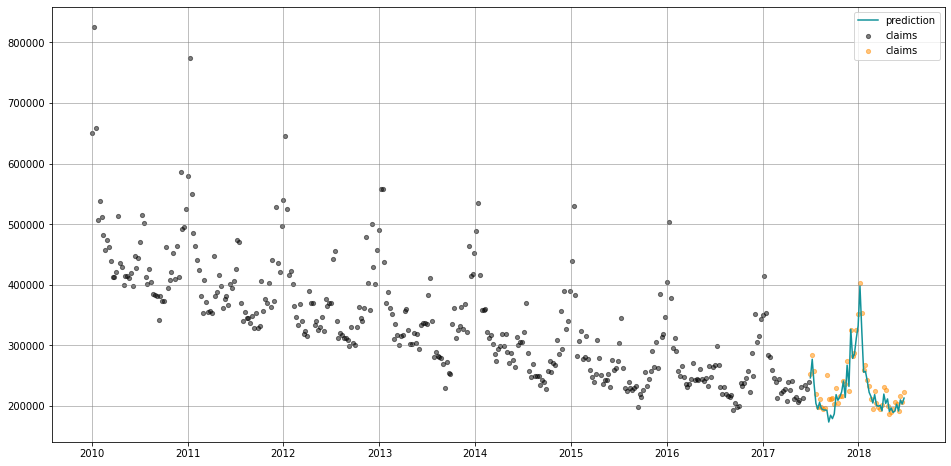

In [11]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [12]:
test_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
391,2017-07-02,252886,1.183973,1.099162,0.919307
392,2017-07-09,284329,1.222792,1.023357,1.025381
393,2017-07-16,257763,1.145154,1.061259,0.990023
394,2017-07-23,220455,1.125745,1.023357,1.025381
395,2017-07-30,198776,1.145154,1.042308,1.048953


## MCMC Fit and Predict

In [13]:
lgt_mcmc = LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    infer_method='mcmc',
    predict_method='full',
    num_warmup=4000, 
    num_sample=500,
    n_bootstrap_draws=-1,
)

In [14]:
%%time
lgt_mcmc.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 145 ms, sys: 151 ms, total: 296 ms
Wall time: 22.4 s


In [15]:
predicted_df = lgt_mcmc.predict(df=test_df)

In [16]:
predicted_df.tail(5)

,week,5,50,95
47,2018-05-27,182841.242100,205046.047556,233642.840210
48,2018-06-03,171205.287008,192525.956832,215776.816044
49,2018-06-10,189289.085220,211801.427929,236942.786885
50,2018-06-17,184046.428367,205146.164204,231392.232511
51,2018-06-24,193999.066956,216771.430236,244369.295494


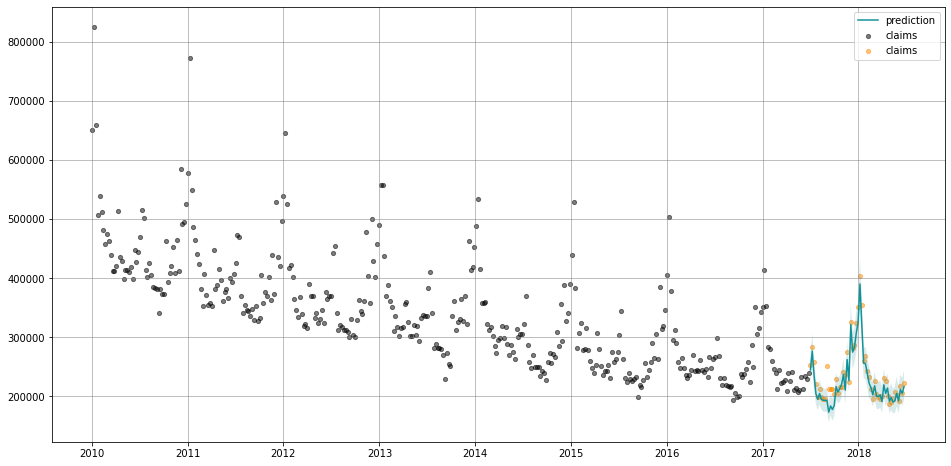

In [17]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_mcmc.date_col, actual_col=lgt_mcmc.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Mean Fit

In [18]:
lgt_mean=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    infer_method='mcmc',
    predict_method='mean',
    num_warmup=4000, 
    num_sample=500,
)

In [19]:
%%time
lgt_mean.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 165 ms, sys: 170 ms, total: 336 ms
Wall time: 31.1 s


In [20]:
predicted_df = lgt_mean.predict(df=test_df)

In [21]:
predicted_df.head(5)

,week,prediction
0,2017-07-02,242111.607175
1,2017-07-09,271466.091382
2,2017-07-16,233641.020907
3,2017-07-23,200988.971794
4,2017-07-30,192537.383168


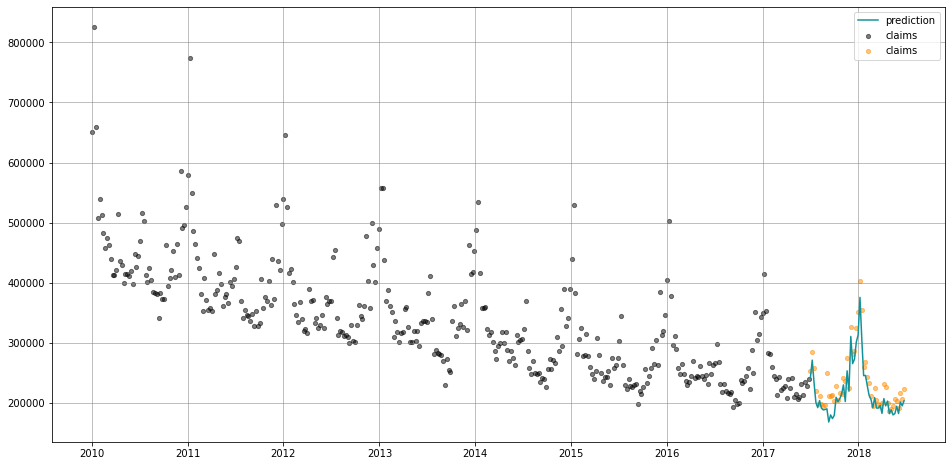

In [22]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_mean.date_col, actual_col=lgt_mean.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## Fit with Regressors & Predict with Decomp

### Fit with Regressors

In [23]:
lgt_reg_map=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    infer_method='map',
    predict_method='map',
)

In [24]:
%%time
lgt_reg_map.fit(df=train_df)

CPU times: user 188 ms, sys: 11 ms, total: 199 ms
Wall time: 202 ms


### Decompose Prediction

We can use `decompose=True` to decompose prediction into `trend`, `seasonality` and `regression` components. This command only works with point estimate.

In [25]:
# make prediction of past and future
predicted_df = lgt_reg_map.predict(df=df, decompose=True)
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2010-01-03,651215.000000,493216.854024,1.337983,0.986816
1,2010-01-10,826082.849794,481985.069422,1.723576,0.994396
2,2010-01-17,650828.708582,480347.271520,1.369878,0.989075
3,2010-01-24,513917.477074,480318.659435,1.076724,0.993710
4,2010-01-31,530108.554071,478202.287989,1.122084,0.987934


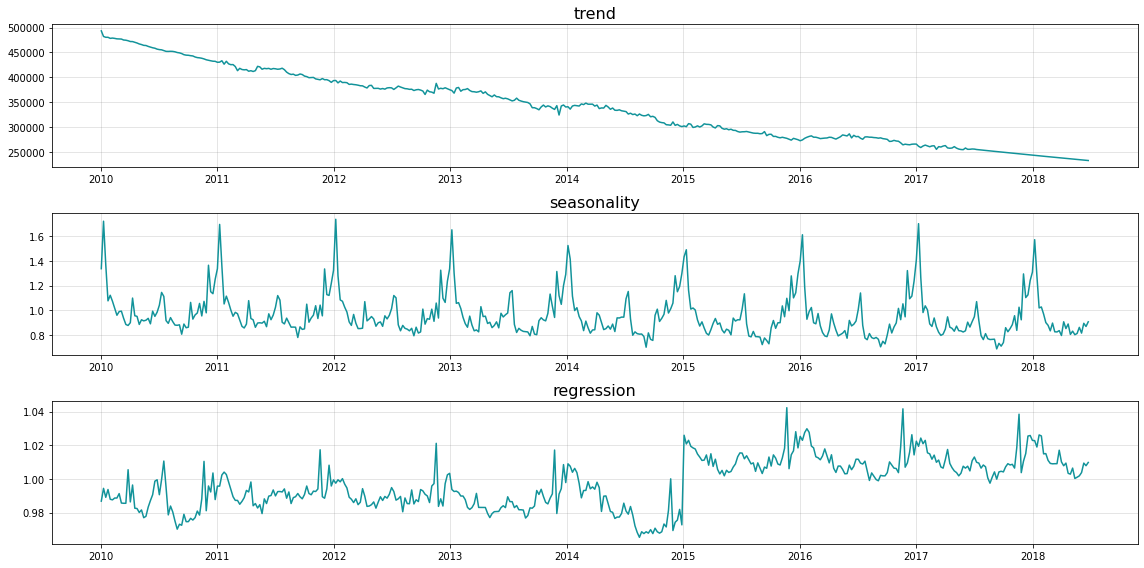

In [26]:
plot_predicted_components(predicted_df=predicted_df, date_col='week')